In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision import tv_tensors
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import torch.optim as optim

cuda = torch.cuda.is_available()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.2.1+cu118  Device: cuda


In [2]:
negative_csv = 'CADDY_gestures_all_true_negatives_release_v2.csv'
positive_csv = 'CADDY_gestures_all_true_positives_release_v2.csv'

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
print("Parent Directory:", parent_directory)

img_directory = os.path.join(parent_directory, 'data', 'raw')

Parent Directory: C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA904-2024S1\projetos\sinais_mergulhadores


In [4]:
df = pd.read_csv(os.path.join(parent_directory, 'data','raw', positive_csv))
df['stereo left'] = img_directory + df['stereo left'].apply(lambda x: x.replace('/', os.sep))
df['stereo right'] = img_directory + df['stereo right'].apply(lambda x: x.replace('/', os.sep))
df.head()

,index,scenario,stereo left,stereo right,label name,label id,roi left,roi right,synthetic,iqa_mdm_entropy,iqa_mdm_d,iqa_mdm_dcomp,distortion,param 1,param 2
0,0,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",0,6.971026,0.957653,0.902,NaN,NaN,NaN
1,1,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,7,NaN
2,2,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,11,NaN
3,3,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,15,NaN
4,4,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,channel noise,5,NaN


In [5]:
df2 = pd.read_csv(os.path.join(parent_directory, 'data', 'raw', negative_csv))
df2['stereo left'] = img_directory + df2['stereo left'].apply(lambda x: x.replace('/', os.sep))
df2['stereo right'] = img_directory + df2['stereo right'].apply(lambda x: x.replace('/', os.sep))
df2.head()

,index,scenario,stereo left,stereo right,selected img,label name,label id,roi params,synthetic,distortion type,dist. param 1,dist. param 2
0,0,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,0,NaN,NaN,NaN
1,1,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,blur,7,NaN
2,2,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,blur,11,NaN
3,3,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,blur,15,NaN
4,4,biograd-A,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,C:\Users\jazg2\OneDrive\Documents\IA904-PCV\IA...,NaN,true_neg,-1,NaN,1,channel noise,5,NaN


In [6]:
#Seleting raw stereo photos
raw_df = df[df['iqa_mdm_entropy'].notnull()].reset_index(drop=True)
raw_df2 = df2[df2['synthetic']==0].reset_index(drop=True)

#Filling in nan values
raw_df.loc[:,'roi left'] = raw_df['roi left'].fillna(str([-1,-1,0,0]))
raw_df.loc[:,'roi right'] = raw_df['roi right'].fillna(str([-1,-1,0,0]))

print(raw_df.shape, raw_df2.shape)

(9239, 15) (7190, 12)


In [7]:
from sklearn.model_selection import train_test_split

#usable_positive_df, _ = train_test_split(raw_df, test_size = 0.25, stratify=raw_df['label id'],random_state=42)
#usable_negative_df, _ = train_test_split(raw_df2, test_size=0.25, random_state = 42)

trainval_df, test_df = train_test_split(raw_df,test_size=0.1, stratify=raw_df['label id'],random_state=42)
train_df, val_df = train_test_split(trainval_df,test_size=0.15, stratify=trainval_df['label id'], random_state=42)

trainval_df2, test_df2 = train_test_split(raw_df2,test_size=0.1, random_state=42)
train_df2, val_df2 = train_test_split(trainval_df2,test_size=0.15, random_state=42)

pos_train_df = train_df.reset_index(drop=True)
pos_val_df   = val_df.reset_index(drop=True)
pos_test_df  = test_df.reset_index(drop=True)

neg_train_df = train_df2.reset_index(drop=True)
neg_val_df   = val_df2.reset_index(drop=True)
neg_test_df  = test_df2.reset_index(drop=True)

print('Training mini-dataset:', len(pos_train_df)+len(neg_train_df))
print('Validation mini-dataset:', len(pos_val_df)+len(neg_val_df))
print('Testing mini-dataset:', len(pos_test_df)+len(neg_test_df))

Training mini-dataset: 12567
Validation mini-dataset: 2219
Testing mini-dataset: 1643


In [28]:
columns = ['stereo left', 'stereo right', 'label id']
joined_df = pd.concat([pos_val_df[columns], neg_val_df[columns]], axis = 0)

# Display the result
print(joined_df.head())

joined_df.to_csv('./test_dataset.csv')

                                         stereo left  \
0  /genova-A/true_positives/raw/genova-A_00726_le...   
1  /brodarski-A/true_positives/raw/brodarski-A_00...   
2  /biograd-A/true_positives/raw/biograd-A_01153_...   
3  /genova-A/true_positives/raw/genova-A_00936_le...   
4  /biograd-C/true_positives/raw/biograd-C_01563_...   

                                        stereo right  label id  
0  /genova-A/true_positives/raw/genova-A_00726_ri...         2  
1  /brodarski-A/true_positives/raw/brodarski-A_00...         0  
2  /biograd-A/true_positives/raw/biograd-A_01153_...         6  
3  /genova-A/true_positives/raw/genova-A_00936_ri...         4  
4  /biograd-C/true_positives/raw/biograd-C_01563_...         5  


In [8]:
#  U - NET
# https://github.com/jaxony/unet-pytorch/blob/master/model.py

def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2)
    else:
        # out_channels is always going to be the same
        # as in_channels
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)

class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))   
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, 
                 merge_mode='concat', up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels, self.out_channels, 
            mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(
                2*self.out_channels, self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5, 
                 start_filts=64, up_mode='transpose', 
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the 
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))
    
        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal_(m.weight)
            init.constant_(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []
         
        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)
        
        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [9]:
device = torch.device('cuda')
unet = UNet(num_classes = 2, in_channels = 3, depth=3, start_filts = 32, merge_mode='concat').to(device)
unet.load_state_dict(torch.load('./unet_ver1.pth'))
summary(unet, (3, 160, 212))
for param in unet.parameters():
    unet.requires_grad = False

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 212]             896
            Conv2d-2         [-1, 32, 160, 212]           9,248
         MaxPool2d-3          [-1, 32, 80, 106]               0
          DownConv-4  [[-1, 32, 80, 106], [-1, 32, 160, 212]]               0
            Conv2d-5          [-1, 64, 80, 106]          18,496
            Conv2d-6          [-1, 64, 80, 106]          36,928
         MaxPool2d-7           [-1, 64, 40, 53]               0
          DownConv-8  [[-1, 64, 40, 53], [-1, 64, 80, 106]]               0
            Conv2d-9          [-1, 128, 40, 53]          73,856
           Conv2d-10          [-1, 128, 40, 53]         147,584
         DownConv-11  [[-1, 128, 40, 53], [-1, 128, 40, 53]]               0
  ConvTranspose2d-12          [-1, 64, 80, 106]          32,832
           Conv2d-13          [-1, 64, 80, 106]          73,792


In [10]:
class GestNet(nn.Module):
    def __init__(self):
        super(GestNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3), padding='same')
        self.batch1= nn.BatchNorm2d(32)
        #self.conv12= nn.Conv2d(32, 32, (5,5), padding='same')
        #self.batch12=nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((2,2), stride=2)
        
        self.conv2 = nn.Conv2d(32, 32, (3,3), padding='same')
        self.batch2= nn.BatchNorm2d(32)
        #self.conv22= nn.Conv2d(32, 32, (5,5), padding='same')
        #self.batch22=nn.BatchNorm2d(32)        
        self.pool2 = nn.MaxPool2d((2,2), stride=2)
        
        self.conv3 = nn.Conv2d(32, 32, (3,3), padding='same')
        self.batch3=nn.BatchNorm2d(32)
        #self.conv32= nn.Conv2d(32, 32, (5,5), padding='same')
        #self.batch32= nn.BatchNorm2d(32)        
        self.pool3 = nn.MaxPool2d((2,2), stride=2)
        
        self.conv4 = nn.Conv2d(32, 32, (3,3), padding='same')
        self.batch4=nn.BatchNorm2d(32)
        self.conv42= nn.Conv2d(32, 32, (5,5), padding='same')
        self.batch42= nn.BatchNorm2d(32)        
        self.pool4 = nn.MaxPool2d((2,2), stride=2)
        
        self.fc1   = nn.Linear(32*13*10, 128)
        self.drop1 = nn.Dropout1d(0.2)
        self.fc2   = nn.Linear(128,64)
        self.drop2 = nn.Dropout1d(0.2)
        self.fc3   = nn.Linear(64,17)

    def forward(self, x):
        #Spatial feature extraction
        x = self.pool1(F.relu(self.batch1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch2(self.conv2(x))))
        x = self.pool3(F.relu(self.batch3(self.conv3(x))))
        x = self.pool4(F.relu(self.batch42(self.conv42(F.relu(self.batch4(self.conv4(x)))))))
        x = x.view(-1, 32*13*10)
        # MLP approximation
        x = F.tanh(self.fc1(x))
        x = self.drop1(x)
        x = F.tanh(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)        
        return x

In [11]:
device = torch.device('cuda')
gest_model = GestNet().to(device)
#gest_model.load_state_dict(torch.load('./scuba_classification2.pth'))
summary(gest_model, (3, 160, 212))
#for param in gest_model.parameters():
#    gest_model.requires_grad = False

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 212]             896
       BatchNorm2d-2         [-1, 32, 160, 212]              64
         MaxPool2d-3          [-1, 32, 80, 106]               0
            Conv2d-4          [-1, 32, 80, 106]           9,248
       BatchNorm2d-5          [-1, 32, 80, 106]              64
         MaxPool2d-6           [-1, 32, 40, 53]               0
            Conv2d-7           [-1, 32, 40, 53]           9,248
       BatchNorm2d-8           [-1, 32, 40, 53]              64
         MaxPool2d-9           [-1, 32, 20, 26]               0
           Conv2d-10           [-1, 32, 20, 26]           9,248
      BatchNorm2d-11           [-1, 32, 20, 26]              64
           Conv2d-12           [-1, 32, 20, 26]          25,632
      BatchNorm2d-13           [-1, 32, 20, 26]              64
        MaxPool2d-14           [-1, 32,

In [12]:
class ImageDataset(Dataset):
    def __init__(self, pos_dataframe, neg_dataframe, transform=None):
        self.pos_df = pos_dataframe
        self.neg_df = neg_dataframe
        self.transform = transform
        #Pre-allocating resources (malloc-like behavior)
        self.data = np.zeros((self.pos_df.shape[0]+self.neg_df.shape[0], 480//3, 640//3-1,3), dtype=np.uint8)
        self.label= np.zeros((self.pos_df.shape[0]+self.neg_df.shape[0]), dtype=np.uint8)
        #not necessary for classification task only
        #self.target = np.zeros((self.pos_df.shape[0]+self.neg_df.shape[0], 480//3, 640//3-1,2), dtype=np.uint8)
        self.obtain_images()

    def obtain_images(self):
        file_col = 'stereo left'
        #Traversing through each row in positive dataset
        for order, row in self.pos_df.iterrows():
            path = row[file_col]
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resizing to ~1/3 of its original size
            self.data[order] = cv2.resize(img, (212, 480//3), interpolation = cv2.INTER_AREA)
            self.label[order] = int(row['label id']) + 1
        #Traversing through each row in negative dataset
        for order, row in self.neg_df.iterrows():
            path = row[file_col]
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resizing to ~1/3 of its original size
            self.data[order+self.pos_df.shape[0]] = cv2.resize(img, (212, 480//3), interpolation = cv2.INTER_AREA)
            
    def normalize(self, image_arr):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())

    def __len__(self):
        return len(self.data)

    def toTensor(self, data):
        image = data.transpose((2,0,1))
        return torch.from_numpy(image)
    
    def __getitem__(self, index):
        x = self.normalize(self.data[index])
        y = self.label[index]
        x = self.toTensor(x)
        if self.transform:
            x = self.transform(x)
        return x,y

In [13]:
train_transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True),
                                    transforms.RandomZoomOut(p=0.20),
                                    transforms.RandomRotation(degrees=(0,20)),
                                    #transforms.RandomPerspective(),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.GaussianBlur(kernel_size=(3,3)),
                                    transforms.RandomAdjustSharpness(sharpness_factor=1.25),
                                    transforms.Resize((160,212))])
                                    #transforms.RandomEqualize()])

valtest_transform = transforms.Compose([transforms.ToDtype(torch.float32, scale=True)])

train_ds = ImageDataset(pos_train_df, neg_train_df, transform=train_transform)
val_ds   = ImageDataset(pos_val_df, neg_val_df, transform=valtest_transform)
test_ds  = ImageDataset(pos_test_df, neg_test_df, transform=valtest_transform)

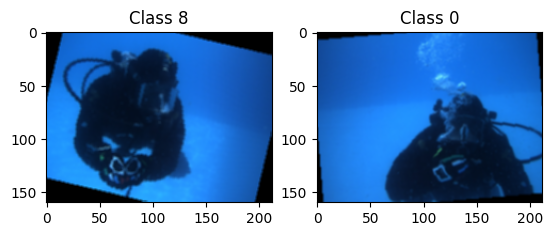

In [14]:
fig, ax = plt.subplots(1,2)

img, label = train_ds[1]
ax[0].imshow(img.numpy().transpose((1, 2, 0)))
ax[0].set_title('Class {}'.format(label))
img, label = train_ds[-1]
#print(label)
ax[1].imshow(img.numpy().transpose((1, 2, 0)))
ax[1].set_title('Class {}'.format(label))
plt.show()

In [17]:
batch_size = 32
validation_size = 1

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(dataset=val_ds, batch_size=validation_size, shuffle=False)

In [18]:
device = torch.device('cuda')
torch.cuda.empty_cache()
train_loss_list = []
val_loss_list = []
train_acc = []
val_acc = []
thresh = 0.999999999
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gest_model.parameters(), lr=0.0005)#0.00005
decay = 0.98
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=decay)
num_epochs = 150
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    gest_model.train()
    for batch in train_loader:
        #Training examples
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        #Mask output
        just_gesture = torch.where(torch.sigmoid(unet(x))[:,1,:,:].unsqueeze(1)>=thresh, x, 0.0)
        pred = gest_model(just_gesture)
        #Loss and Backpropagation
        optimizer.zero_grad()
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        #Training performance
        running_loss += loss.item()*x.size(0)
        _, predicted_train = torch.max(pred, 1)
        total_train += x.size(0)
        correct_train += (predicted_train == y).sum().item()
    scheduler.step()
    train_accuracy = correct_train / total_train
    train_loss = running_loss/len(train_loader.dataset)
    train_acc.append(train_accuracy)
    train_loss_list.append(train_loss)
    gest_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        test_loss = 0.0
        for sample in test_loader:
            #Label prediction
            x, y = sample
            x = x.to(device)
            y = y.to(device)
            just_gesture = torch.where(torch.sigmoid(unet(x))[:,1,:,:].unsqueeze(1)>=thresh, x, 0.0)
            y_pred = gest_model(just_gesture)
            #Peformance evaluation
            _, label_pred = torch.max(y_pred, 1)
            total += x.size(0)
            correct += (label_pred == y).sum().item()
            test_loss += loss_fn(y_pred, y)*x.size(0) # sum up batch loss
        val_loss_list.append(test_loss/len(test_loader))     
        val_accuracy = correct / total
        val_acc.append(val_accuracy)
        val_loss = test_loss/len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2%}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2%}")

Epoch 1/150, Train Loss: 2.0401, Train Accuracy: 39.74%, Val Loss: 1.5262, Val Accuracy: 55.45%
Epoch 2/150, Train Loss: 1.8870, Train Accuracy: 47.29%, Val Loss: 1.4357, Val Accuracy: 57.03%
Epoch 3/150, Train Loss: 1.7852, Train Accuracy: 51.68%, Val Loss: 1.4408, Val Accuracy: 58.37%
Epoch 4/150, Train Loss: 1.7227, Train Accuracy: 53.45%, Val Loss: 1.3562, Val Accuracy: 58.43%
Epoch 5/150, Train Loss: 1.6832, Train Accuracy: 54.30%, Val Loss: 1.2423, Val Accuracy: 63.48%
Epoch 6/150, Train Loss: 1.6215, Train Accuracy: 55.92%, Val Loss: 1.2010, Val Accuracy: 61.84%
Epoch 7/150, Train Loss: 1.5571, Train Accuracy: 57.13%, Val Loss: 1.1170, Val Accuracy: 64.94%
Epoch 8/150, Train Loss: 1.5171, Train Accuracy: 58.45%, Val Loss: 1.0056, Val Accuracy: 70.60%
Epoch 9/150, Train Loss: 1.5146, Train Accuracy: 58.71%, Val Loss: 1.1130, Val Accuracy: 66.65%
Epoch 10/150, Train Loss: 1.4569, Train Accuracy: 59.87%, Val Loss: 0.9464, Val Accuracy: 72.67%
Epoch 11/150, Train Loss: 1.4277, Train

In [35]:
torch.save(gest_model.state_dict(), './udw_model.pth')

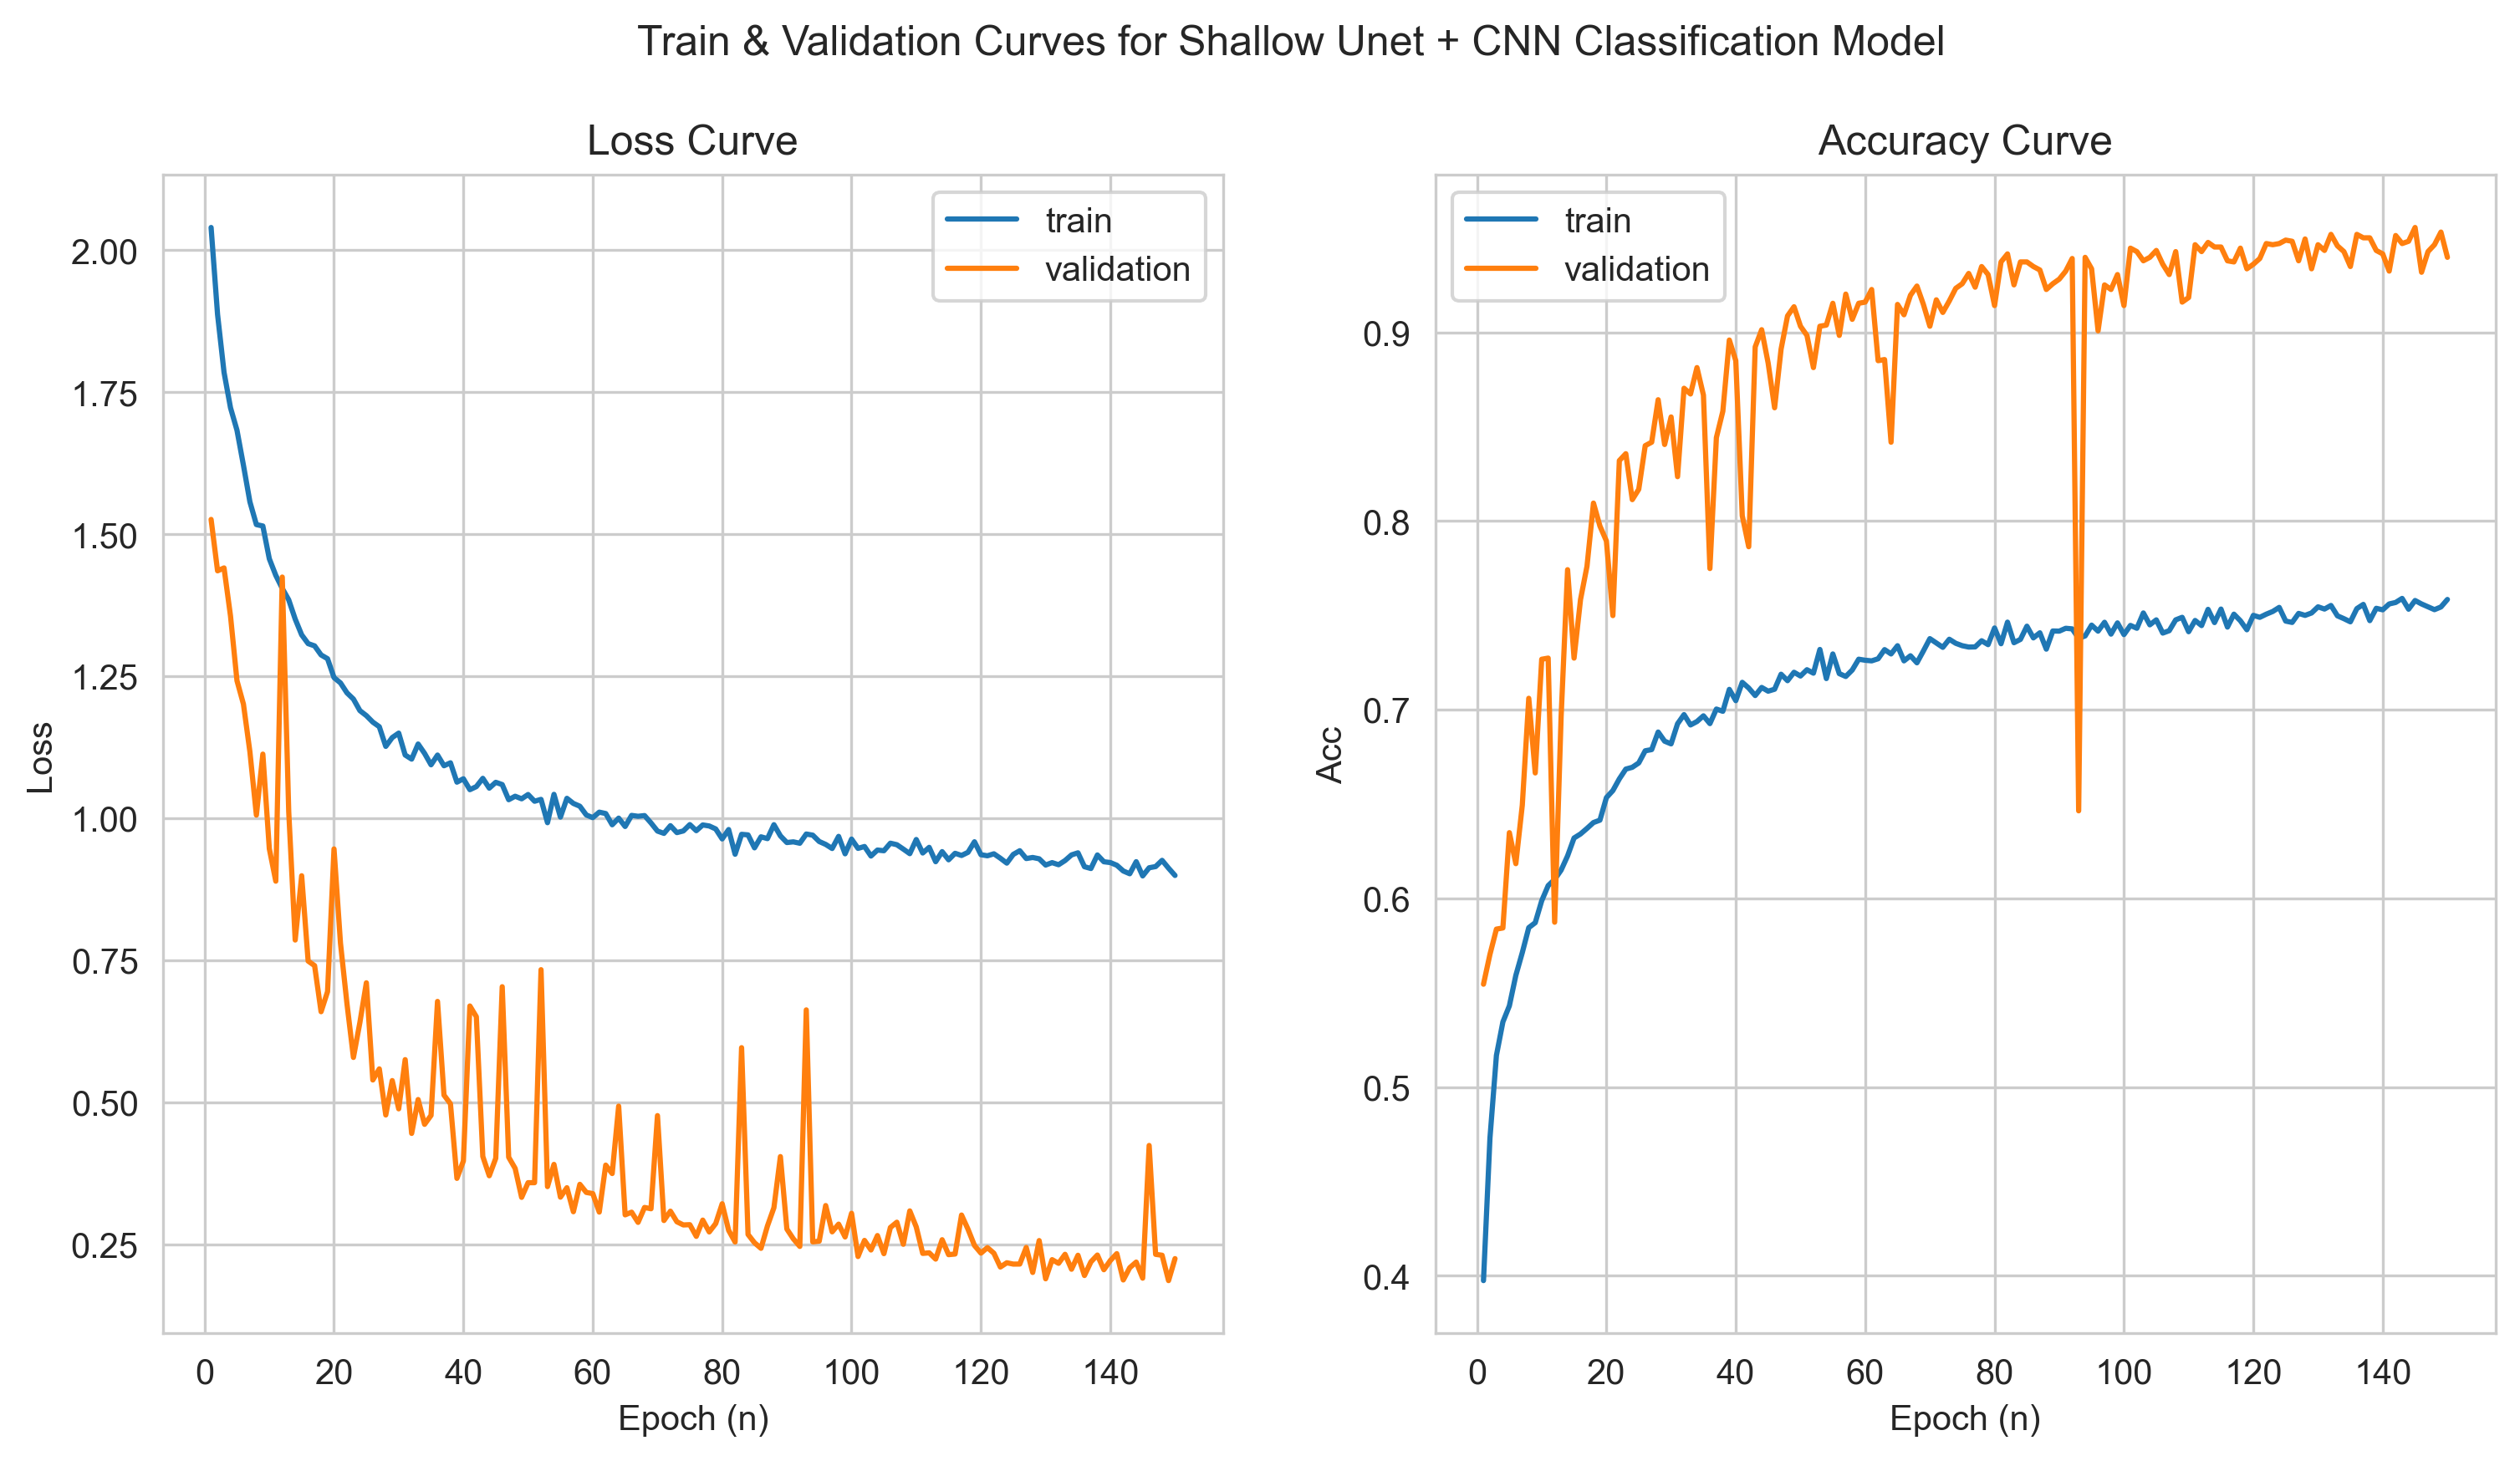

In [19]:
import seaborn as sns
sns.set_style('whitegrid')

trn_loss = np.array(([val for val in train_loss_list]))
val_loss = np.array(([val.cpu()*len(test_loader)/len(test_loader.dataset) for val in val_loss_list]))

plt.figure(figsize = (12,6), dpi = 300)
plt.suptitle('Train & Validation Curves for Shallow Unet + CNN Classification Model')
plt.subplot(121)
plt.plot(range(1,150+1), trn_loss, label='train')
plt.plot(range(1,150+1), val_loss, label='validation')
plt.legend()
plt.xlabel('Epoch (n)')
plt.ylabel('Loss')
plt.title('Loss Curve')
#plt.xticks(range(1,100+1, 1))
plt.subplot(122)
plt.plot(range(1,150+1), train_acc, label='train')
plt.plot(range(1,150+1), val_acc, label='validation')
plt.title('Accuracy Curve')
plt.xlabel('Epoch (n)')
plt.ylabel('Acc')
#plt.xticks(range(1,100+1, 1))
plt.legend()
plt.savefig('./curves_classification_gestures.png')
plt.show()

In [20]:
from sklearn.metrics import classification_report

#Testing on outside dataset
gest_model.eval()
test_loss = 0.0
correct = 0
total = 0
pred = []
batch_loss = 0.0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(validation_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        just_gesture = torch.where(torch.sigmoid(unet(inputs))[:,1,:,:].unsqueeze(1)>=thresh, inputs, 0.0)
        outputs = gest_model(just_gesture)
        loss = loss_fn(outputs, labels)
        batch_loss += loss.item() * inputs.size(0)  # sum up batch loss
         # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        iter_size = labels.size(0)
        pred.extend(predicted.detach().cpu().numpy().tolist())#pred[i*batch_size:i*batch_size+iter_size] = predicted.detach().cpu().numpy()
        #true[i*batch_size:i*batch_size+iter_size] = labels.detach().cpu().numpy()
test_loss = batch_loss / len(validation_loader.dataset)
# Calculate validation accuracy
test_accuracy = correct / total
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.2%}')

Test loss: 0.2155
Test accuracy: 95.04%


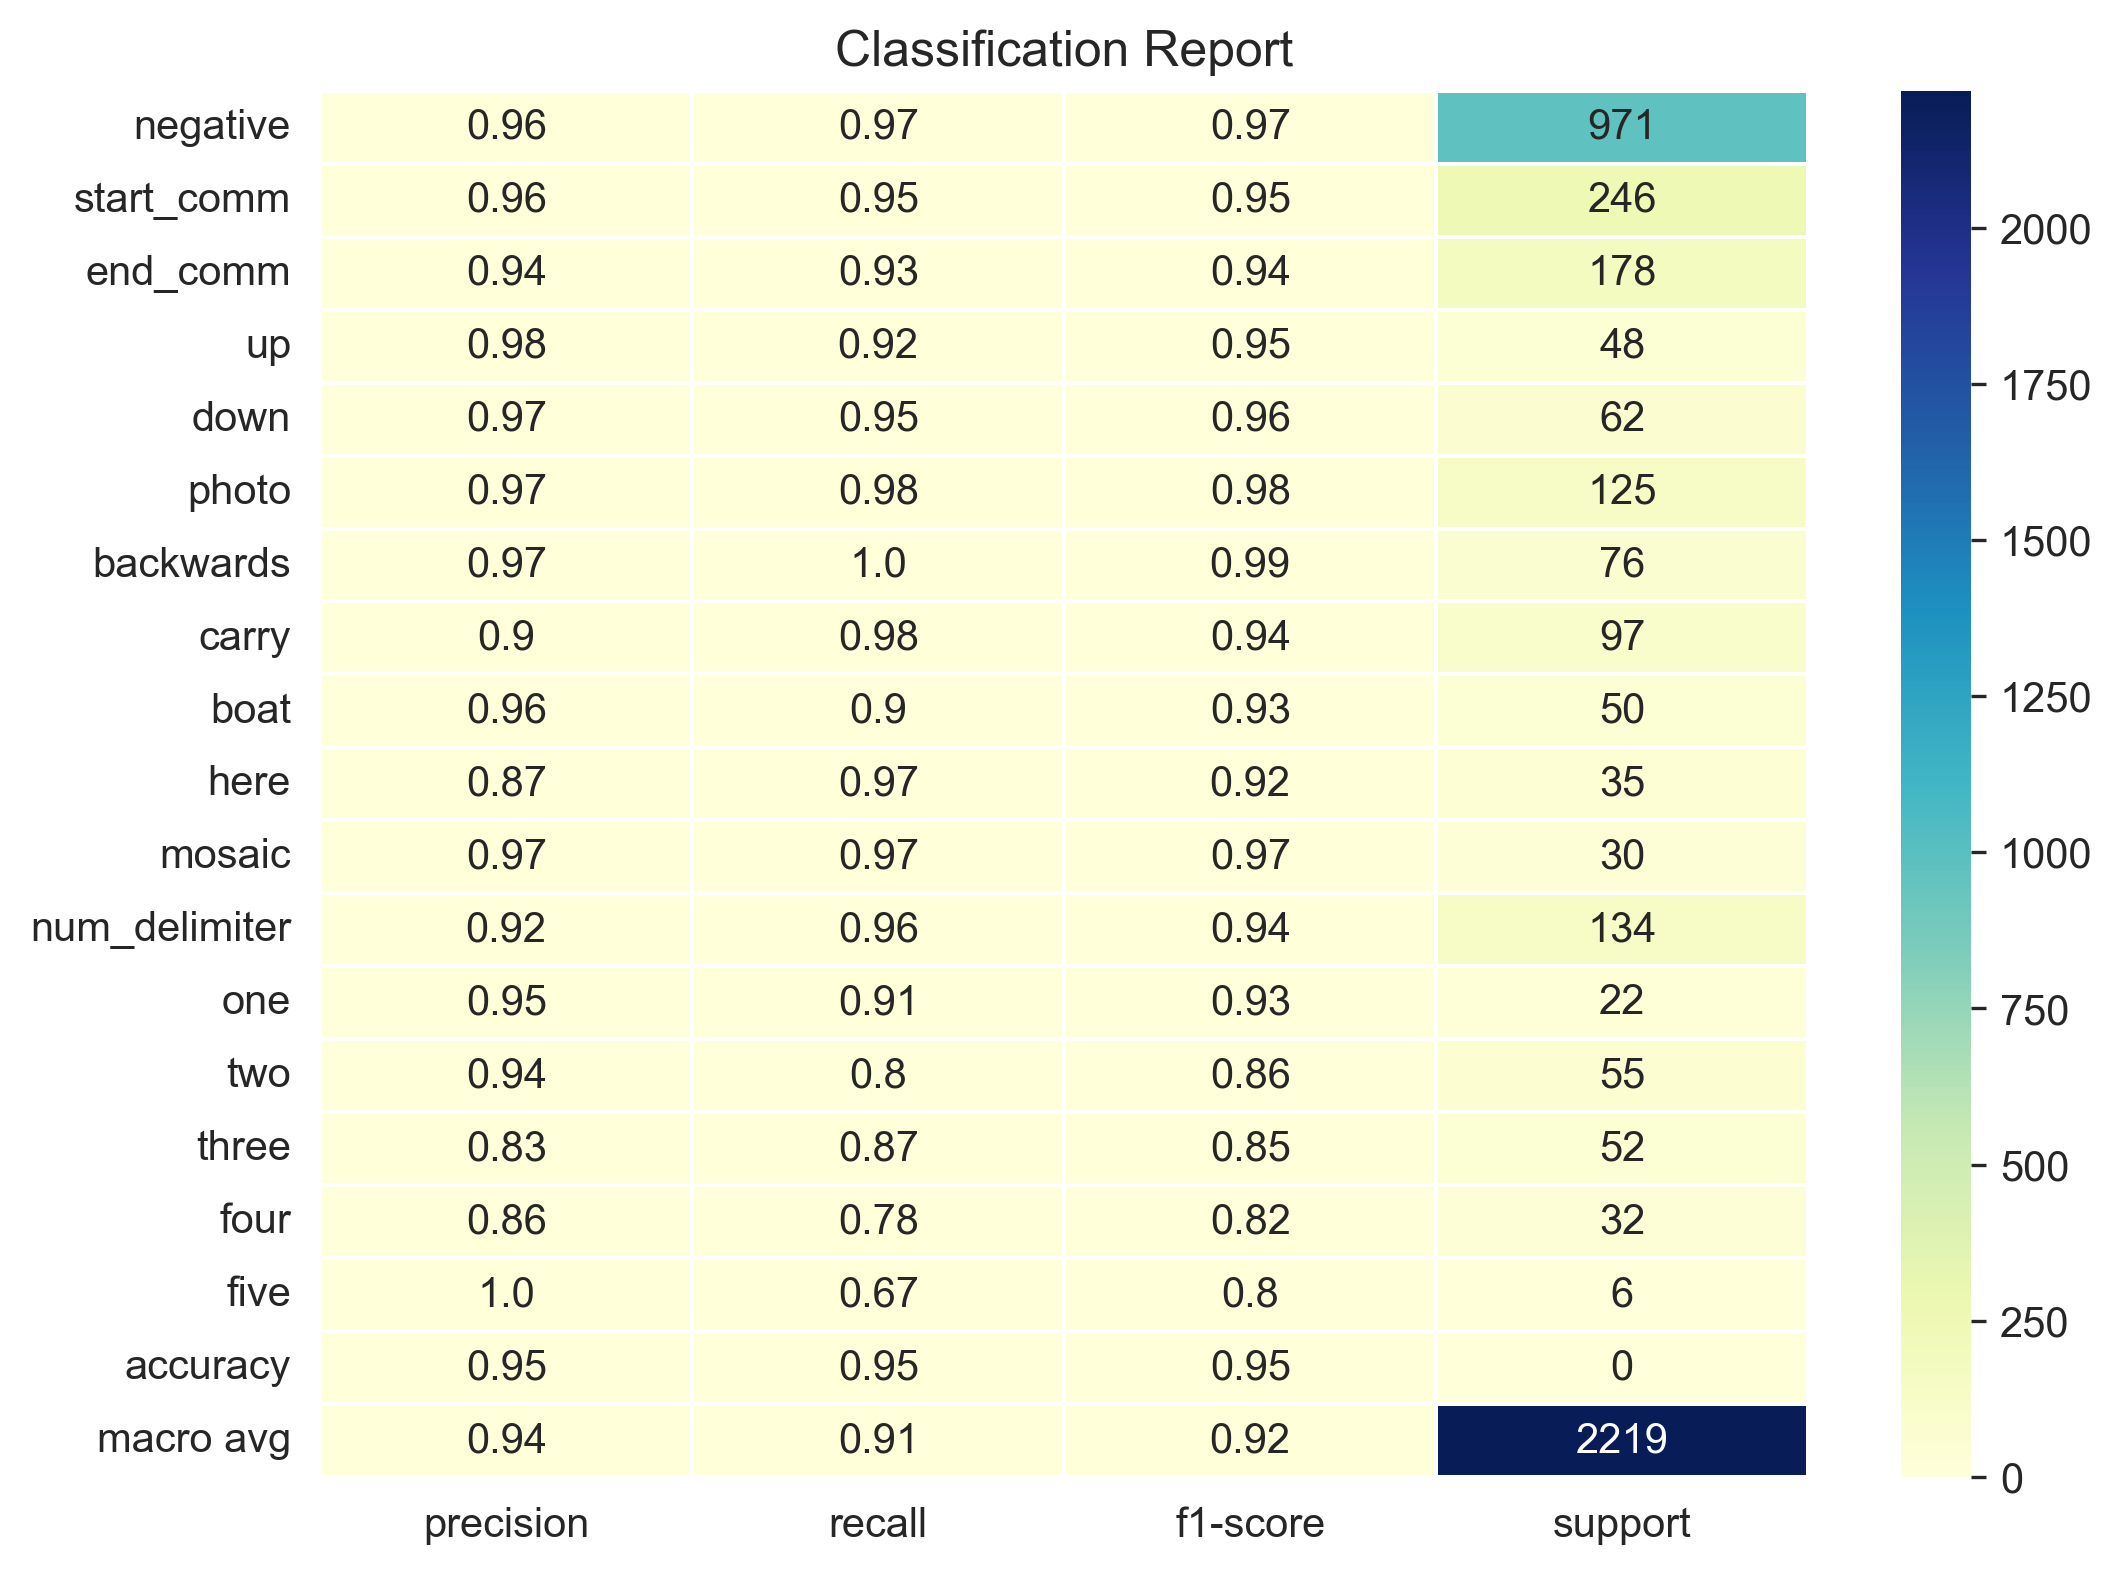

In [33]:
# Generate classification report

target_names = ['negative', 'start_comm', 'end_comm', 'up', 
                'down', 'photo', 'backwards', 'carry', 'boat', 'here', 
                'mosaic', 'num_delimiter', 'one', 'two', 'three', 'four', 'five']
report = classification_report(val_ds.label, pred, target_names=target_names, output_dict=True)
# Print the classification report
#print(report)

df_report = pd.DataFrame(report).transpose()
df_report['support'] = df_report['support'].astype(int)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6), dpi= 300)
sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=df_report.iloc[:-1, :].round(2).astype(str), cmap="YlGnBu", linewidths=.5, fmt="")
plt.title('Classification Report')
plt.savefig('./classification_report.png')
plt.show()

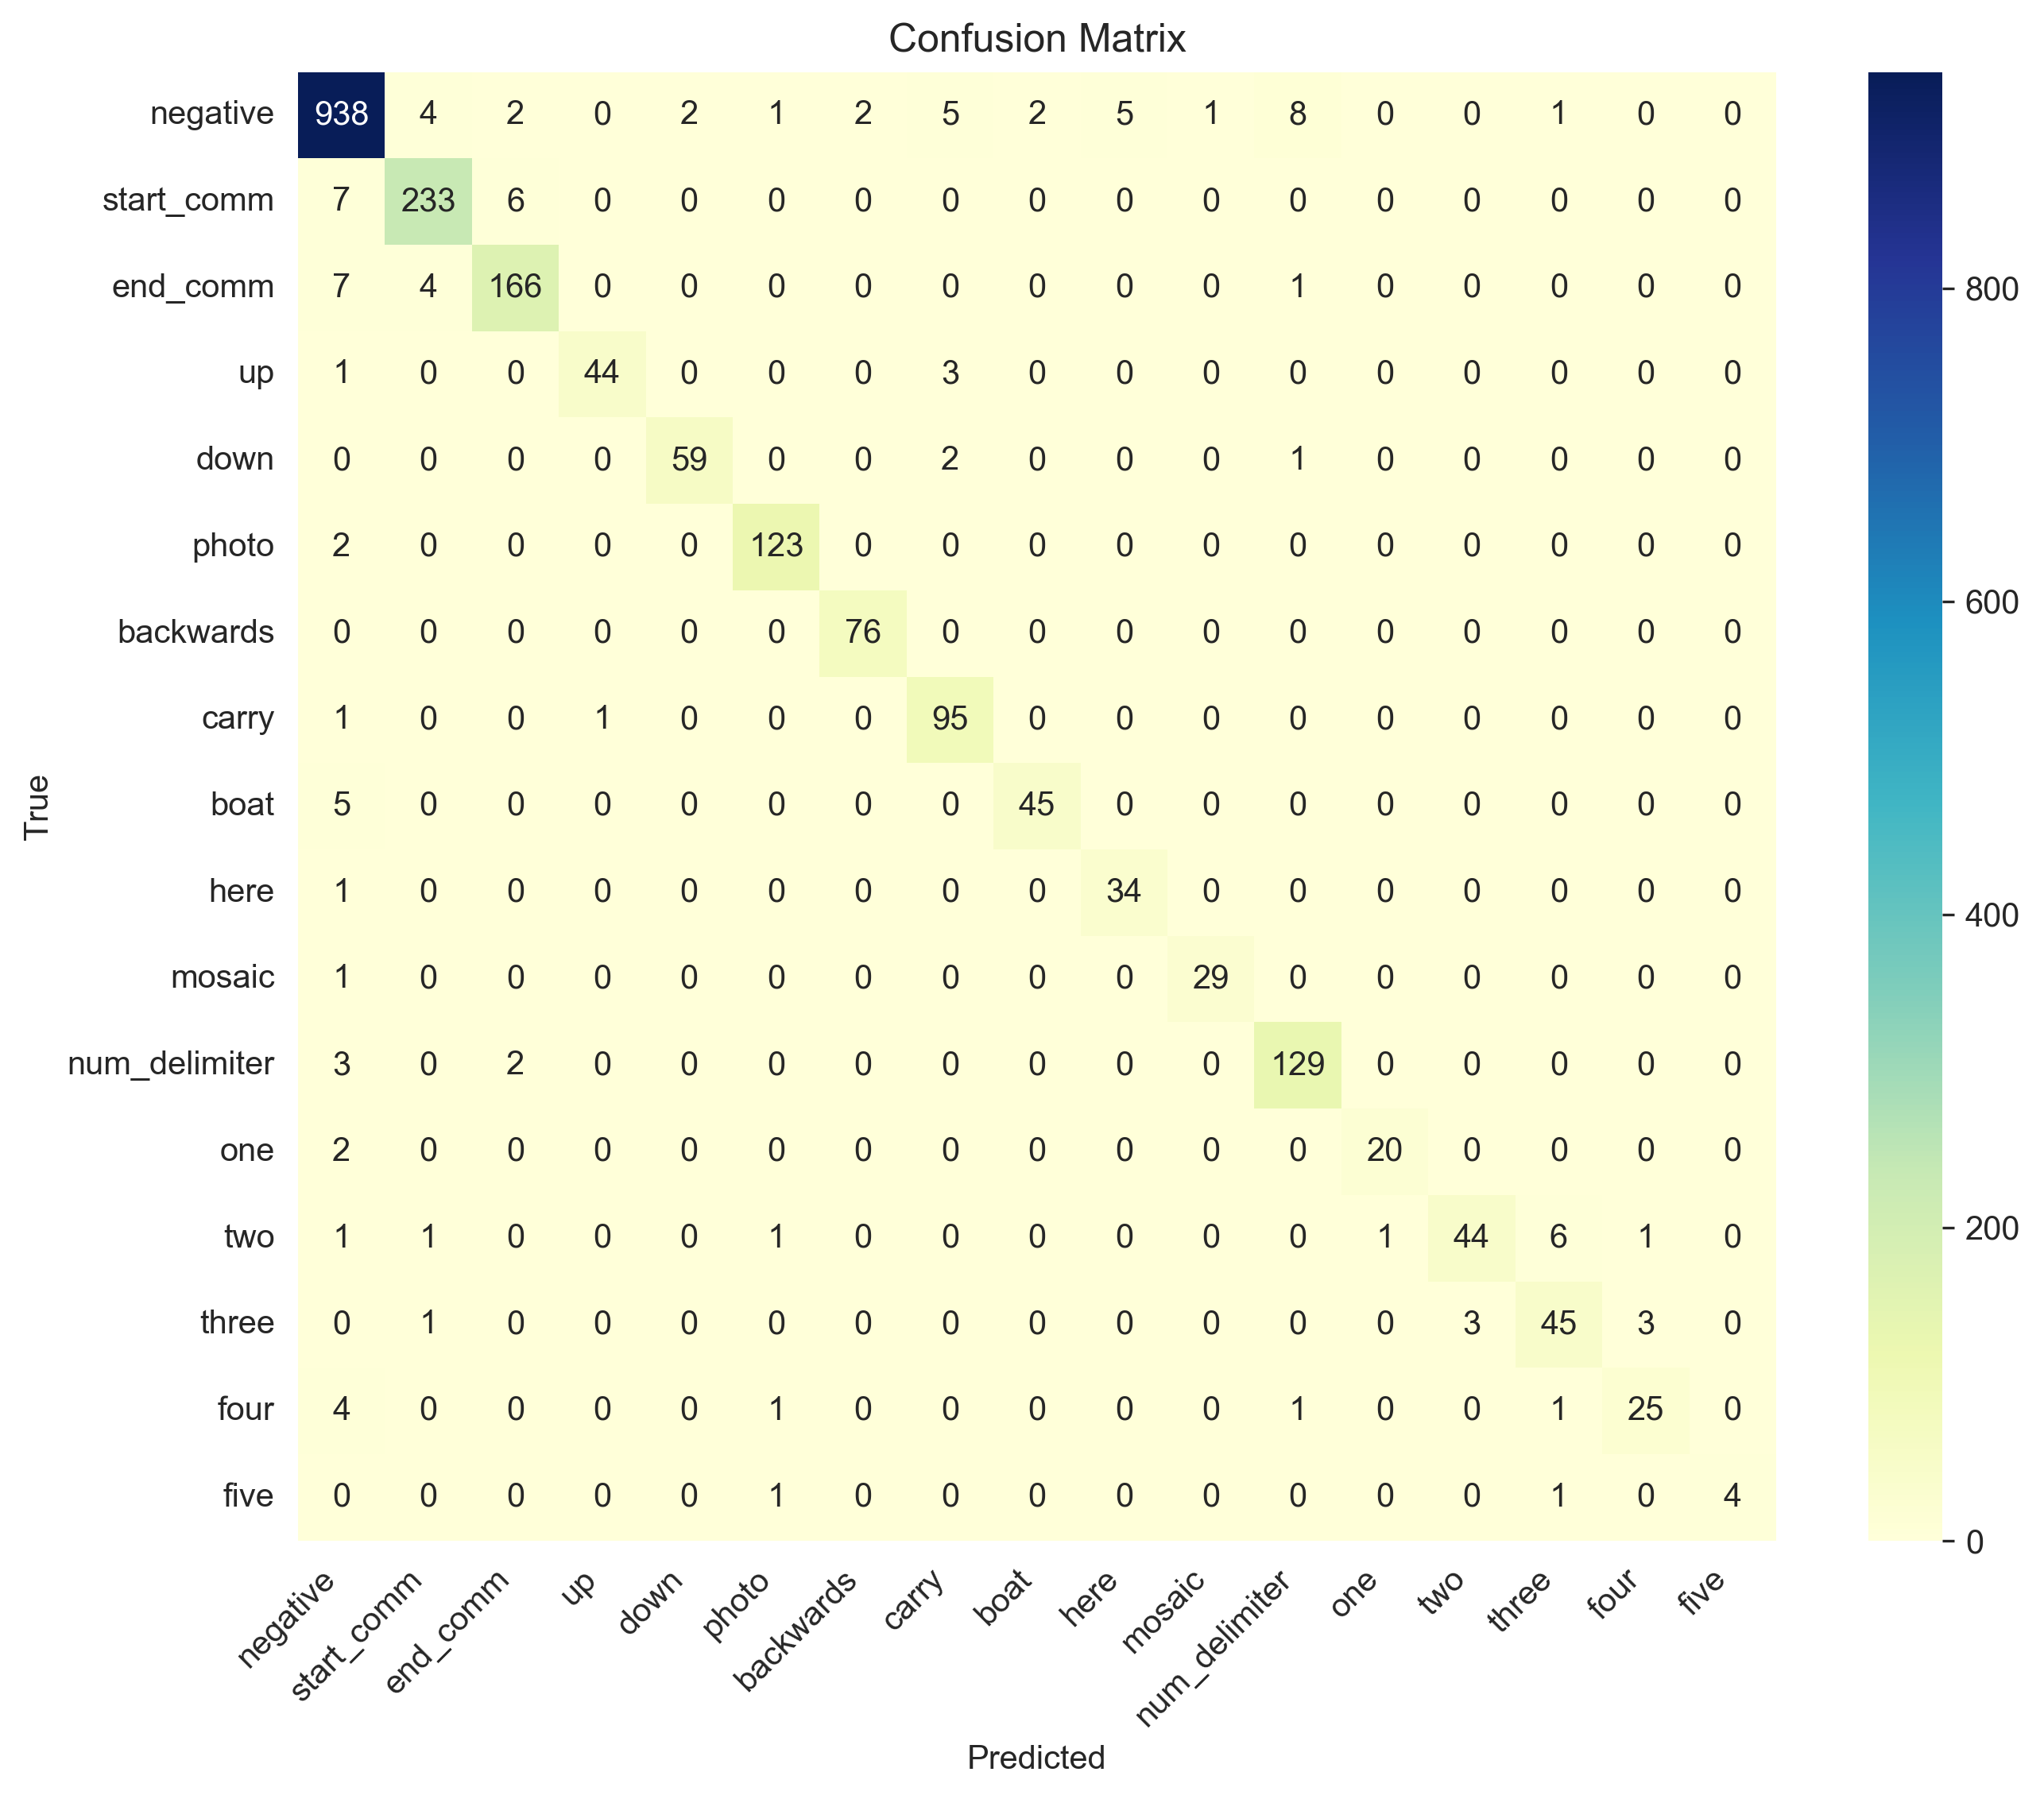

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(val_ds.label, pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8), dpi = 300)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.xticks(np.arange(len(target_names))+0.5, target_names, rotation=45, ha='right')
plt.yticks(np.arange(len(target_names))+0.5, target_names, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('conf_matrix.png')
plt.show()

In [37]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(val_ds.label, pred)
print('Matthews Correlation Coefficient: {:.2f}'.format(mcc))

Matthews Correlation Coefficient: 0.94
